In [1]:
import sys
sys.path.append('..')
import numpy as np
from common import config
# config.GPU = True
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

In [ ]:
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 读入数据
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

# 生成上下文和目标词，即输入和正确解
contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# 生成模型
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 开始学习
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 保存必要数据，以便后续使用
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

在CPU上训练特别慢，因此在colab平台上使用GPU进行了训练，如下为一次训练结果

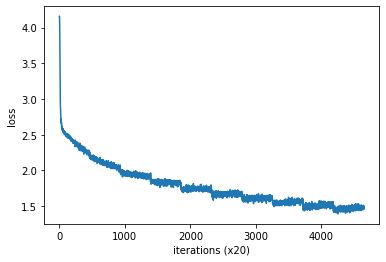

## 评估

In [6]:
from common.util import most_similar, analogy
import pickle

In [14]:
pkl_file = 'cbow_params1.pkl'
pickle_protocol = 4

In [15]:
with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

In [16]:
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.732421875
 i: 0.6923828125
 your: 0.61376953125
 they: 0.59228515625
 else: 0.56298828125

[query] year
 month: 0.84912109375
 week: 0.77587890625
 summer: 0.7587890625
 spring: 0.73974609375
 decade: 0.66259765625

[query] car
 luxury: 0.64453125
 truck: 0.61279296875
 cars: 0.60546875
 auto: 0.603515625
 vehicle: 0.5888671875

[query] toyota
 honda: 0.646484375
 seita: 0.63037109375
 nissan: 0.62841796875
 tires: 0.61865234375
 chevrolet: 0.60986328125


In [17]:
word_vecs.shape

(10000, 100)

从上面的结果可以看到，由CBOW模型获得的单词的分布式表示有良好的性质

### 类推问题

要解决类推问题，需要在单词向量空间上寻找尽可能使“man → woman”向量和“king → ?”向量接近的单词

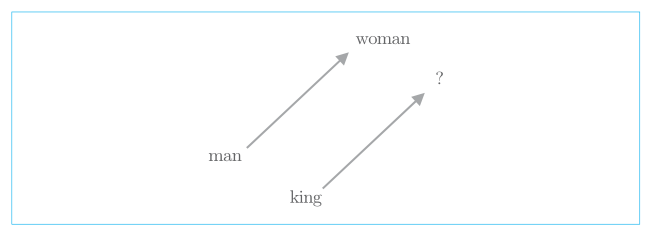

In [19]:
# analogy task
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)

--------------------------------------------------

[analogy] king:man = queen:?
 a.m: 5.8671875
 woman: 5.23046875
 carolinas: 4.7421875
 naczelnik: 4.7109375
 husband: 4.66796875

[analogy] take:took = go:?
 eurodollars: 4.92578125
 're: 4.65625
 came: 4.41796875
 went: 4.34375
 were: 4.15234375

[analogy] car:cars = child:?
 a.m: 6.5859375
 children: 5.515625
 rape: 5.34765625
 incest: 5.29296875
 males: 5.18359375

[analogy] good:better = bad:?
 more: 5.81640625
 rather: 5.796875
 less: 5.61328125
 greater: 4.53515625
 worse: 4.23046875
